In [1]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"

In [2]:
patient_hup_id = 210
fs = 1024
# Initialize an empty list to hold the data
data = []

# Iterate through all files in the directory
for filename in os.listdir(SPIKES_OUTPUT_DIR):
    # Check if the file ends with .npy
    if filename.endswith(".npy"):
        # Use regular expression to match the pattern and extract desired numbers
        match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

        if match:
            current_patient_hup_id = int(match.group(1))
            if current_patient_hup_id != patient_hup_id:
                continue
            interval_index = int(match.group(2))

            # Append the data to the list
            data.append(
                {
                    "filename": filename,
                    "interval_index": interval_index,
                }
            )

# Convert the list of dictionaries to a pandas DataFrame
spike_files_df = pd.DataFrame(data)
# Sort the DataFrame by the interval index
spike_files_df = spike_files_df.sort_values(by="interval_index")
# Reset the index
spike_files_df = spike_files_df.reset_index(drop=True)
# Add a new column called "start_sample_index"
spike_files_df["start_sample_index"] = spike_files_df["interval_index"] * fs * 60 * 2
spike_files_df

,filename,interval_index,start_sample_index
0,HUP210_phaseII_562.npy,562,69058560
1,HUP210_phaseII_576.npy,576,70778880
2,HUP210_phaseII_577.npy,577,70901760
3,HUP210_phaseII_586.npy,586,72007680
4,HUP210_phaseII_589.npy,589,72376320
...,...,...,...
2079,HUP210_phaseII_2771.npy,2771,340500480
2080,HUP210_phaseII_2772.npy,2772,340623360
2081,HUP210_phaseII_2773.npy,2773,340746240
2082,HUP210_phaseII_2774.npy,2774,340869120


In [11]:
# Initialize an empty list to store individual DataFrames
dfs = []

for index, row in spike_files_df.iterrows():
    filename = row["filename"]
    start_sample_index = row["start_sample_index"]

    # Load the data
    spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

    # Convert all values to int
    spike_data = spike_data.astype(int)

    # Adjust the start_sample_index
    spike_data[:, 0] += start_sample_index

    # Convert the modified spike_data to a DataFrame and append to the dfs list
    dfs.append(
        pd.DataFrame(
            spike_data,
            columns=["peak_index", "channel_index", "sequence_index"],
        )
    )

# Concatenate all the individual DataFrames into a single DataFrame
all_spikes_df = pd.concat(dfs, ignore_index=True)

all_spikes_df

,peak_index,channel_index,sequence_index
0,69114386,40,0
1,69114427,0,0
2,69116031,40,1
3,69116031,39,1
4,70886208,0,0
...,...,...,...
306081,341072634,7,10
306082,341072636,8,10
306083,341072655,92,10
306084,341091922,69,11


KeyError: 'start_sample_index'

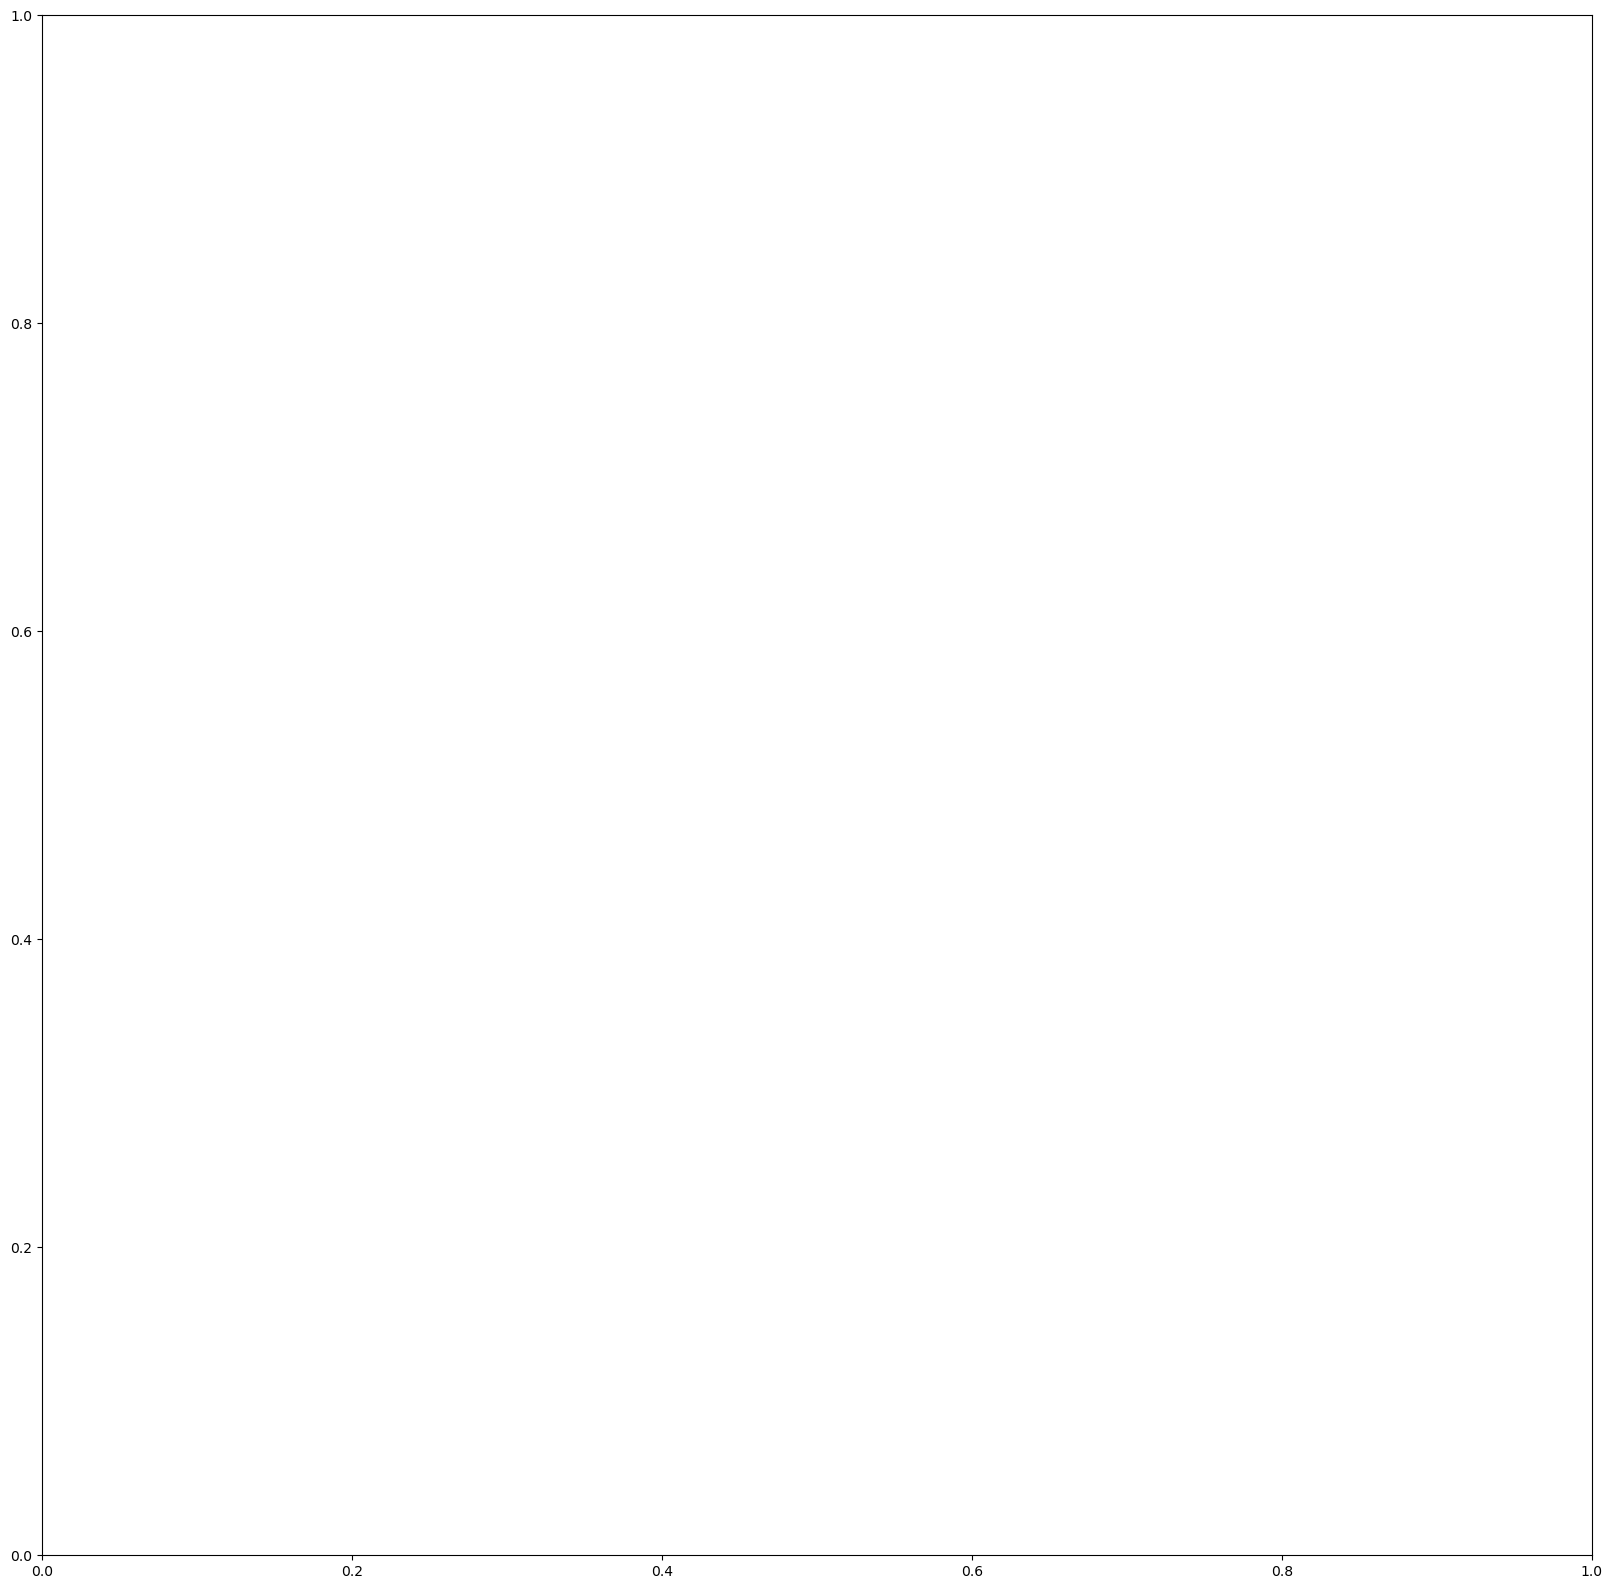

In [12]:
def raster_plot(df):
    fig, ax = plt.subplots(figsize=(20, 20))
    # Iterate through unique channels
    for channel in df["channel_index"].unique():
        # Extract spike times for this channel
        spike_times = df[df["channel_index"] == channel]["peak_index"]
        ax.plot(spike_times, [channel] * len(spike_times), "k.", markersize=2)

    ax.set_ylabel("Channel")
    ax.set_xlabel("Sample Index")
    ax.set_title("Raster Plot")
    ax.invert_yaxis()  # Optional: to have channel 0 at the top
    plt.show()


raster_plot(all_spikes_df)

## Inter-spike intervals

## Cascade size distribution